# Mercari Price Suggestion Challenge (EDA)
This competition is hosted by [Mercari](!https://www.mercari.com/), Japan’s biggest community-powered shopping app. They provide a hassle-free and secure way for anyone to buy and sell stuff straight from their mobile device.

In this competition, we are asked to build an algorithm to predict the sale price of a product based on information a user provides for this product. The schema of the data is as follows:
 * train_id or test_id - the id of the listing
 * name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. \$20) to avoid leakage. These removed prices are represented as [rm]
 * item_condition_id - the condition of the items provided by the seller
category_name - category of the listing
 * brand_name
 * price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.
 * shipping - 1 if shipping fee is paid by seller and 0 by buyer
 * item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

In this Notebook, we perform exploratory data analysis (EDA).

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import text

import matplotlib.pyplot as plt
%matplotlib inline

### Load the training data into a Pandas dataframe

In [2]:
df = pd.read_csv('../input/train.tsv', sep='\t')
df = df.drop(['train_id'], axis=1)
df.head(2)

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...


In [3]:
## We will work with a samller subset for code development and test 
#df = df.sample(n=None, frac=0.05)
#print (len(df))
#df.head(2)

### Check for missing values

In [4]:
print ('Total number of rows in training set: {:d}'.format(len(df)))

print ('\nNumber of missing values')
df.isnull().sum(axis=0)

Total number of rows in training set: 1482535

Number of missing values


name                      0
item_condition_id         0
category_name          6327
brand_name           632682
price                     0
shipping                  0
item_description          4
dtype: int64

### Fill missing values
 * A missing category name becomes 'Other'
 * A missing brand name becomes 'Unknown'
 * A missing item description becomes 'No description yet'

In [5]:
class MissingValuesHandler(BaseEstimator, TransformerMixin):
    # Extracts a given list of columns from the input dataframe and returns a new dataframe
    
    def __init__(self, col_name_replacevalue_tuples):
        self.col_name_replacevalue_tuples = col_name_replacevalue_tuples
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        for (col, val) in self.col_name_replacevalue_tuples:
            df[col] = df[col].fillna(val)
        return df

In [6]:
missing_values_handler = MissingValuesHandler([('category_name', 'Other'), 
                                               ('brand_name', 'Unknown'), 
                                               ('item_description', 'No description yet')]
                                             )
df = missing_values_handler.fit_transform(df)

### Price distribution

In [7]:
print ('Price ranges from ${:.2f} to ${:.2f}'.format(min(df['price']), max(df['price'])))

Price ranges from $0.00 to $2009.00


(-10, 260)

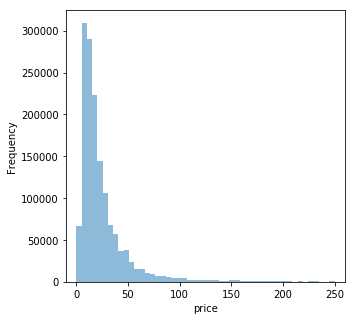

In [8]:
# Price histogram
fig, ax = plt.subplots(figsize=(5,5))
ax.hist(df['price'], bins=np.linspace(0,250,50), alpha=0.5)#, label='')
ax.set_xlabel('price')
ax.set_ylabel('Frequency')
ax.set_xlim(-10,260)

Distribution of 'price' is right skewed. Let's take a log, i.e. log(price+1). We add 1 because some listings have 0 price. 

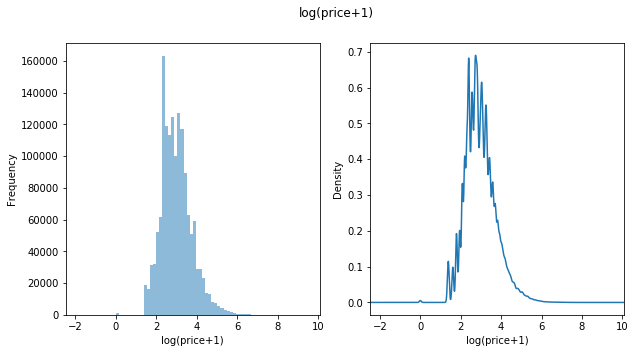

In [9]:
def plot_logprice_hist_and_kde(df, num_bins=50):
    fig, ax = plt.subplots(ncols=2, figsize=(10,5))
    
    # Histogram
    ax[0].hist(np.log(df['price']+1), bins=num_bins, alpha=0.5)#, label='')
    #ax[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax[0].set_xlabel('log(price+1)')
    ax[0].set_ylabel('Frequency')

    # KDE plot
    np.log(df['price']+1).plot(kind='kde', ax=ax[1])#, legend=True)
    #ax[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    ax[1].set_xlabel('log(price+1)')
    ax[1].set_ylabel('Density')
    
    # Match x-axis limits
    xlims_hist = (ax[0].get_xlim())
    xlims_kde = (ax[1].get_xlim())
    tuples = [xlims_hist, xlims_kde]
    new_xlims = [sum(y)/len(y) for y in zip(*tuples)]
    ax[0].set_xlim(new_xlims)
    ax[1].set_xlim(new_xlims)
    
    fig.suptitle('log(price+1)', fontsize=12)
    
    
plot_logprice_hist_and_kde(df, num_bins=50)

Log transformation has more symmetric distribution. We will use this transformation in our predictive model.

### Shipping
Shipping is a dummy variable; 1 if shipping fee is paid by seller and 0 by buyer. We expect the price to be lower for items where shipping is paid by the seller. 

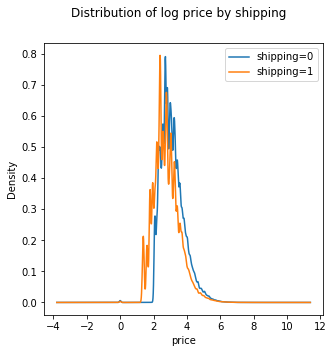

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
np.log(df[df['shipping']==0]['price']+1).plot(kind='kde', label='shipping=0')
np.log(df[df['shipping']==1]['price']+1).plot(kind='kde', label='shipping=1')
ax.set_xlabel('price')
ax.set_ylabel('Density')
ax.legend()#loc='center left', bbox_to_anchor=(1.0, 0.5))
fig.suptitle('Distribution of log price by shipping', fontsize=12)

### Categories
Each item is hierarchically classified into 3 subcategories. For example 'Men/Sweats & Hoodies/Hoodie'. We convert subcategories into lists and use them as one-hot-encoded features in our predictive model. The main category is stored in a separate column called 'cat_1'. There are 11 unique main categories.

In [11]:
regex = r'\b\w+\b'
regex = r'[^-\w]+'
pattern_alphanumeric = re.compile('([^\s\w]|_)+')

class CategoriesProcessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat_col):
        self.cat_col = cat_col
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        df['cat_1'] = df[self.cat_col].apply(lambda x: str(x).split()[0])        
        df[self.cat_col] = df[self.cat_col].apply(lambda x: self.parse_categories_line(x))        
        return df
        
    def parse_categories_line(self, line):
        try:
            cats = ' '.join(line.split('/')[:3]) 
            cats = re.sub('-','', line)
            cats = cats.lower()
                   # convert to lowercase
            cats = pattern_alphanumeric.sub(' ', cats)
                   # Remove everything except alphanumeric characters            
            return cats
        except:
            return ['Other']

categories_processor = CategoriesProcessor('category_name').fit_transform(df).iloc[:10]

### Item description tf-idf
Now we generate tf-idf features using 'item_description' column.

In [12]:
pattern_alphanumeric = re.compile('([^\s\w]|_)+')
pattern_numeric = re.compile('[0-9]+')
pattern_rem_multi_spaces = re.compile('\s\s+')
pattern_words = re.compile(r'\w*\d\w*')


class TextCleaner(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, df, y=None):
        return self
    
    def transform(self, df):
        result_df = df[self.columns[0]]
        for col in self.columns[1:]:
            result_df += " " + df[col]
        result_df = result_df \
                    .apply(lambda x: self.string_cleanup(str(x)))
        return result_df.values
        
    def string_cleanup(self, string):
        string = string.strip()
                # Remove leading and trailing whitespaces from EmployerName
        string = string.lower()
                # convert to lowercase
        string = pattern_alphanumeric.sub(' ', string)
                # Remove everything except alphanumeric characters
        string = pattern_numeric.sub('', string).strip()
                # Remove numbers
        string = pattern_rem_multi_spaces.sub(' ', string)
                # Replace multiple whitespaces by a single whitespace    
        return string    
    
    
#TextCleaner(['item_description', 'name']).fit_transform(df.iloc[:2])

In [13]:
stop_words = text.ENGLISH_STOP_WORDS.union(["rm"])

tfidf_vectorizer = TfidfVectorizer(max_features = 25000, 
                                   ngram_range = (1,2),
                                   stop_words = stop_words)

description_pipe = Pipeline([('text_cleaner', TextCleaner(['item_description'])),
                             ('vectorizer', tfidf_vectorizer)
                            ])

description_features = description_pipe.fit_transform(df, y=None)

In [14]:
#  create a dictionary mapping the tokens to their idf scores
vectorizer = description_pipe.named_steps['vectorizer']
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
idf = pd.DataFrame(columns=['idf']).from_dict(dict(idf), orient='index')
idf.columns = ['idf']

In [15]:
# tokens with the lowest idf score
idf.sort_values(by=['idf'], ascending=True).head(10)

,idf
new,2.171149
size,2.326017
brand,2.743339
condition,2.797614
brand new,2.860643
free,2.892814
shipping,3.063314
worn,3.103477
used,3.161584
great,3.342792


In [16]:
# tokens with the highest idf score
idf.sort_values(by=['idf'], ascending=False).head(10)

,idf
candles discount,12.031211
pcs oz,11.808067
sheet choose,11.808067
oz pcs,11.625746
dollars lanyards,11.425075
color inch,11.380623
hidrocor,11.338064
holika,11.317444
cup normal,11.297242
salt lamp,11.297242


As expected, tokens with low idf score are very generic words while tokens with high idf score are more specific.

### Name tf-idf
Now we generate tf-idf features using 'name' column.

In [17]:
stop_words = text.ENGLISH_STOP_WORDS.union(["rm"])

tfidf_vectorizer = TfidfVectorizer(max_features = 25000, 
                                   ngram_range = (1,2),
                                   stop_words = stop_words)

name_pipe = Pipeline([('text_cleaner', TextCleaner(['name'])),
                      ('vectorizer', tfidf_vectorizer)
                     ])

name_features = name_pipe.fit_transform(df, y=None)
#name_features

In [18]:
#  create a dictionary mapping the tokens to their tfidf scores
vectorizer = name_pipe.named_steps['vectorizer']
idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
idf = pd.DataFrame(columns=['idf']).from_dict(dict(idf), orient='index')
idf.columns = ['idf']

In [19]:
# tokens with the lowest tf-idf score
idf.sort_values(by=['idf'], ascending=True).head(10)

,idf
pink,3.877993
bundle,3.947394
new,3.961425
size,4.004047
lularoe,4.151431
black,4.272112
nike,4.464512
vs,4.509577
secret,4.599763
dress,4.631252


In [20]:
# tokens with the highest tf-idf score
idf.sort_values(by=['idf'], ascending=False).head(10)

,idf
holika,12.264826
hei,12.264826
kissy,12.164742
ta,12.073770
sale sale,11.913428
love love,11.877060
skating,11.808067
limitless,11.808067
doki,11.808067
bree,11.808067


These tokens seem to be less useful but we will include them anyway in this preliminary model.

### Score brands by price
We calculate a score for each brand as follows: for each category-brand pair we calculate the ratio of median price of all items of that brand belonging to a category and median price of all items in that category. The final brand score is the average of these ratios over all categories.

In [21]:
class BrandScoreCalculator(BaseEstimator, TransformerMixin):
    # Returns fuzzy match score between EmployerName and Description of the transaction
    
    def __init__(self, brand_col, cat_col, price_col, cutoff_count=10):
        self.brand_col = brand_col
        self.cat_col = cat_col
        self.price_col = price_col 
        self.cutoff_count = cutoff_count
    
    def fit(self, df, y=None):
        df_median_cat_price = df.groupby([self.cat_col])[self.price_col].agg(['median']).add_prefix('price_')
        self.median_cat_price = {k: v[0] for k,v in df_median_cat_price.T.to_dict('list').items()}
        
        self.brand_counts = df.groupby(self.brand_col)[self.brand_col].agg(['count']).add_prefix('brand_') #.reset_index()
        
        self.brand_score = {k: 0 for k in df[self.brand_col].unique()}
        gr = df.groupby([self.brand_col])
        for k, v in gr:
            df_temp = v.groupby([self.cat_col, self.brand_col])[self.price_col].agg(['median']).add_prefix('price_').reset_index()
            df_temp['cat_price_ratio'] = df_temp[[self.cat_col, self.brand_col, 'price_median']] \
                                         .apply(lambda x: self.cat_price_ratio(x[self.cat_col], x[self.brand_col], x['price_median']), axis=1)
            self.brand_score[k] = df_temp['cat_price_ratio'].mean()

        self.df_brand_score = pd.DataFrame(list(self.brand_score.items()), columns=['brand', 'brand_score'])        
        return self
    
     
    def transform(self, df):
        return df[self.brand_col].apply(lambda x: self.get_price_ratio(x))
        
    def cat_price_ratio(self, cat, brand, price):
        if price==0 or self.brand_counts.loc[brand].values<self.cutoff_count:
            return 1.0
        return price/self.median_cat_price[cat]

    def get_price_ratio(self, brand):
        try:
            return self.brand_score[brand]
        except KeyError:
            return 1.0
        
    def get_brand_scores(self):
        return self.df_brand_score.sort_values(by='brand_score', ascending=False)

In [22]:
brand_score_calculator = BrandScoreCalculator('brand_name', 'cat_1', 'price', cutoff_count = 10)
brand_score_calculator.fit(df, None)
df_brand_score = brand_score_calculator.get_brand_scores().iloc[:20]

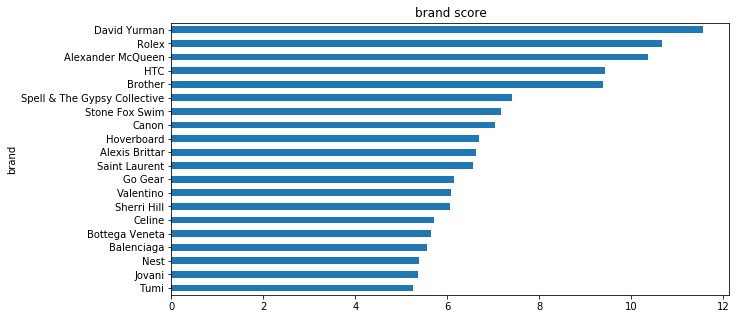

In [23]:
ax = df_brand_score.iloc[:20].plot.barh(x='brand', y='brand_score', 
                                        figsize=(10,5), 
                                        title='brand score',
                                        legend=False)
ax.invert_yaxis()